In [2]:
!pip install tensorflow keras matplotlib numpy scikit-learn

In [7]:

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, Add, Input, ReLU, DepthwiseConv2D, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, InceptionV3, ResNet50, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
tf.keras.mixed_precision.set_global_policy('mixed_float16')



In [8]:

# Dataset Preparation
!kaggle datasets download -d reevald/geometric-shapes-mathematics

# Extract dataset
import zipfile
with zipfile.ZipFile("geometric-shapes-mathematics.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

# Paths
train_dir = "/content/data/dataset/train"
val_dir = "/content/data/dataset/val"
test_dir = "/content/data/dataset/test"

# Preprocessing and Data Augmentation
img_height, img_width = 128, 128
batch_size = 150

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_data = train_datagen.flow_from_directory(
    train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical'
)
val_data = val_test_datagen.flow_from_directory(
    val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical'
)
test_data = val_test_datagen.flow_from_directory(
    test_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', shuffle=False
)

# Class Weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))


Dataset URL: https://www.kaggle.com/datasets/reevald/geometric-shapes-mathematics
License(s): CC0-1.0
geometric-shapes-mathematics.zip: Skipping, found more recently modified local copy (use --force to force download)
Found 12000 images belonging to 8 classes.
Found 4000 images belonging to 8 classes.
Found 4000 images belonging to 8 classes.


In [9]:

# Define Models with Adjusted Learning Rates

from tensorflow.keras.optimizers import Adam

# CNN
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn((img_height, img_width, 3), train_data.num_classes)

# VGG19
def build_vgg19(input_shape, num_classes):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

vgg19_model = build_vgg19((img_height, img_width, 3), train_data.num_classes)

# ResNet
def build_resnet(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet_model = build_resnet((img_height, img_width, 3), train_data.num_classes)

# InceptionNet
def build_inception(input_shape, num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

inception_model = build_inception((img_height, img_width, 3), train_data.num_classes)

# MobileNet
def build_mobilenet(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mobilenet_model = build_mobilenet((img_height, img_width, 3), train_data.num_classes)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:

# Training All Models
models = [cnn_model, vgg19_model, resnet_model, inception_model, mobilenet_model]
model_names = ['CNN', 'VGG19', 'ResNet', 'Inception', 'MobileNet']
histories = []

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
]

for model, name in zip(models, model_names):
    print(f"Training {name}...")
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=20,
        class_weight=class_weights,
        callbacks=callbacks
    )
    histories.append(history)
    print(f"{name} training complete!")


Training CNN...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 91s 733ms/step - accuracy: 0.1659 - loss: 2.8888 - val_accuracy: 0.1752 - val_loss: 2.1088 - learning_rate: 1.0000e-04
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 59s 669ms/step - accuracy: 0.2408 - loss: 2.2637 - val_accuracy: 0.1497 - val_loss: 2.2181 - learning_rate: 1.0000e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 687ms/step - accuracy: 0.2862 - loss: 2.1073 - val_accuracy: 0.1727 - val_loss: 2.5157 - learning_rate: 1.0000e-04
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 59s 679ms/step - accuracy: 0.3069 - loss: 1.9762 - val_accuracy: 0.2023 - val_loss: 2.4121 - learning_rate: 1.0000e-04
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 83s 684ms/step - accuracy: 0.3308 - loss: 1.8797 - val_accuracy: 0.2262 - val_loss: 2.1345 - learning_rate: 2.0000e-05
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 80s 674ms/step - accuracy: 0.3462 - loss: 1.8056 - val_accuracy: 0.3245 - val_loss: 1.7985 - learning_rate: 2.0000e-05
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 84s 679ms/step - accuracy: 0.35

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step


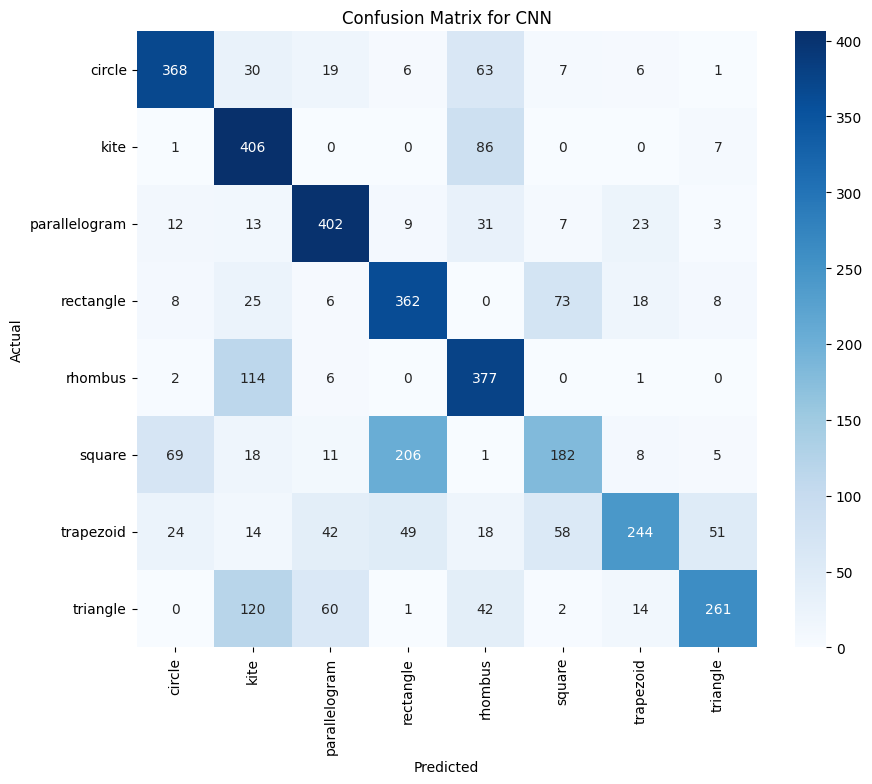

Classification Report for CNN:

               precision    recall  f1-score   support

       circle       0.76      0.74      0.75       500
         kite       0.55      0.81      0.65       500
parallelogram       0.74      0.80      0.77       500
    rectangle       0.57      0.72      0.64       500
      rhombus       0.61      0.75      0.67       500
       square       0.55      0.36      0.44       500
    trapezoid       0.78      0.49      0.60       500
     triangle       0.78      0.52      0.62       500

     accuracy                           0.65      4000
    macro avg       0.67      0.65      0.64      4000
 weighted avg       0.67      0.65      0.64      4000

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step


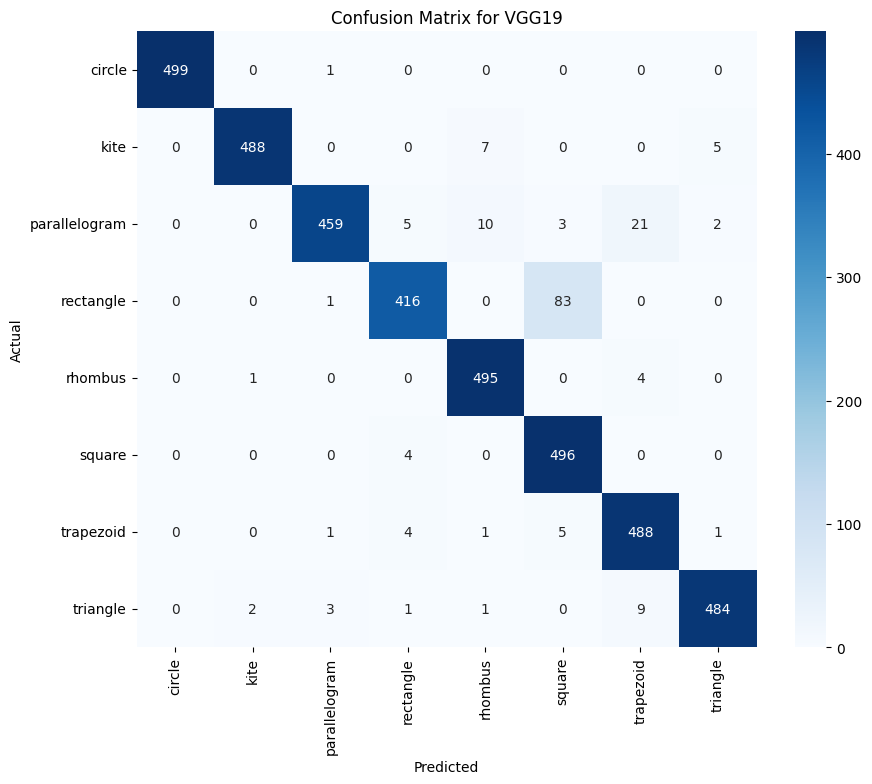

Classification Report for VGG19:

               precision    recall  f1-score   support

       circle       1.00      1.00      1.00       500
         kite       0.99      0.98      0.98       500
parallelogram       0.99      0.92      0.95       500
    rectangle       0.97      0.83      0.89       500
      rhombus       0.96      0.99      0.98       500
       square       0.84      0.99      0.91       500
    trapezoid       0.93      0.98      0.95       500
     triangle       0.98      0.97      0.98       500

     accuracy                           0.96      4000
    macro avg       0.96      0.96      0.96      4000
 weighted avg       0.96      0.96      0.96      4000

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 294ms/step


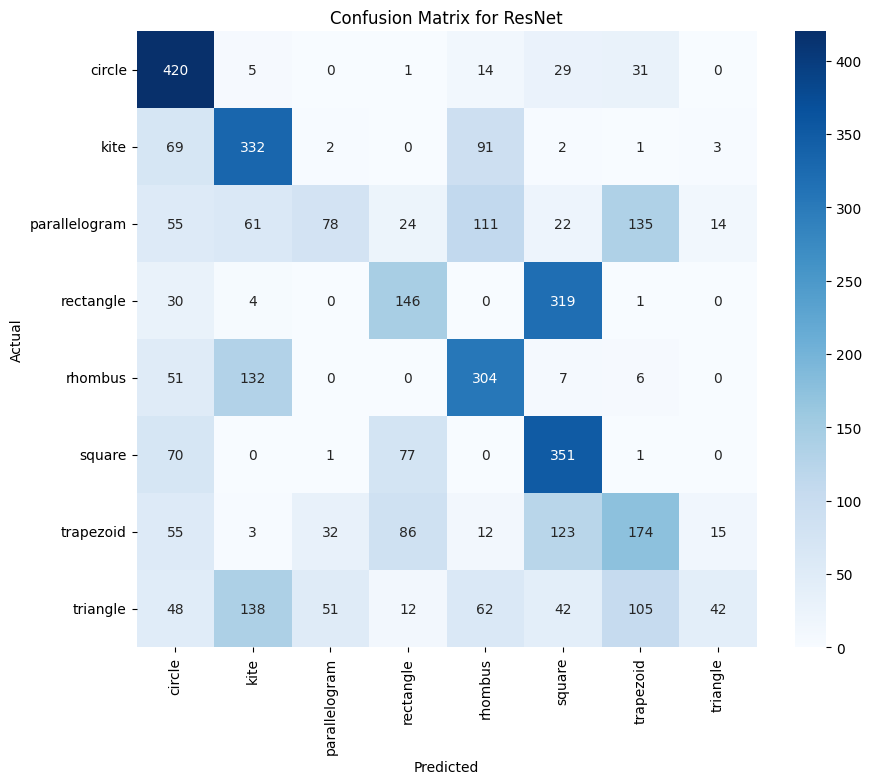

Classification Report for ResNet:

               precision    recall  f1-score   support

       circle       0.53      0.84      0.65       500
         kite       0.49      0.66      0.57       500
parallelogram       0.48      0.16      0.23       500
    rectangle       0.42      0.29      0.35       500
      rhombus       0.51      0.61      0.56       500
       square       0.39      0.70      0.50       500
    trapezoid       0.38      0.35      0.36       500
     triangle       0.57      0.08      0.15       500

     accuracy                           0.46      4000
    macro avg       0.47      0.46      0.42      4000
 weighted avg       0.47      0.46      0.42      4000

27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 318ms/step


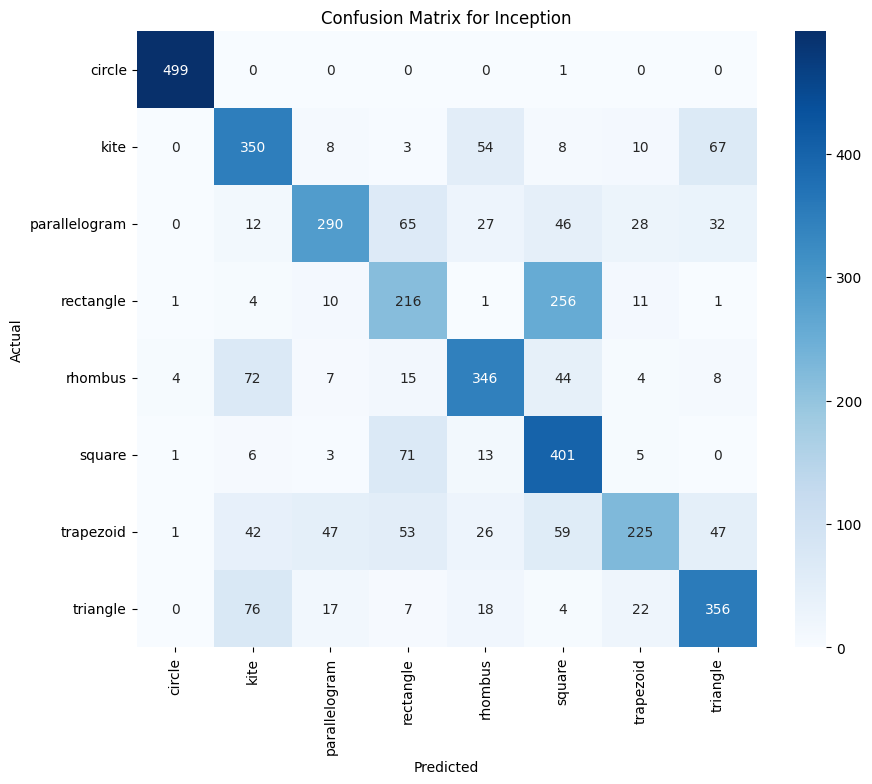

Classification Report for Inception:

               precision    recall  f1-score   support

       circle       0.99      1.00      0.99       500
         kite       0.62      0.70      0.66       500
parallelogram       0.76      0.58      0.66       500
    rectangle       0.50      0.43      0.46       500
      rhombus       0.71      0.69      0.70       500
       square       0.49      0.80      0.61       500
    trapezoid       0.74      0.45      0.56       500
     triangle       0.70      0.71      0.70       500

     accuracy                           0.67      4000
    macro avg       0.69      0.67      0.67      4000
 weighted avg       0.69      0.67      0.67      4000

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step


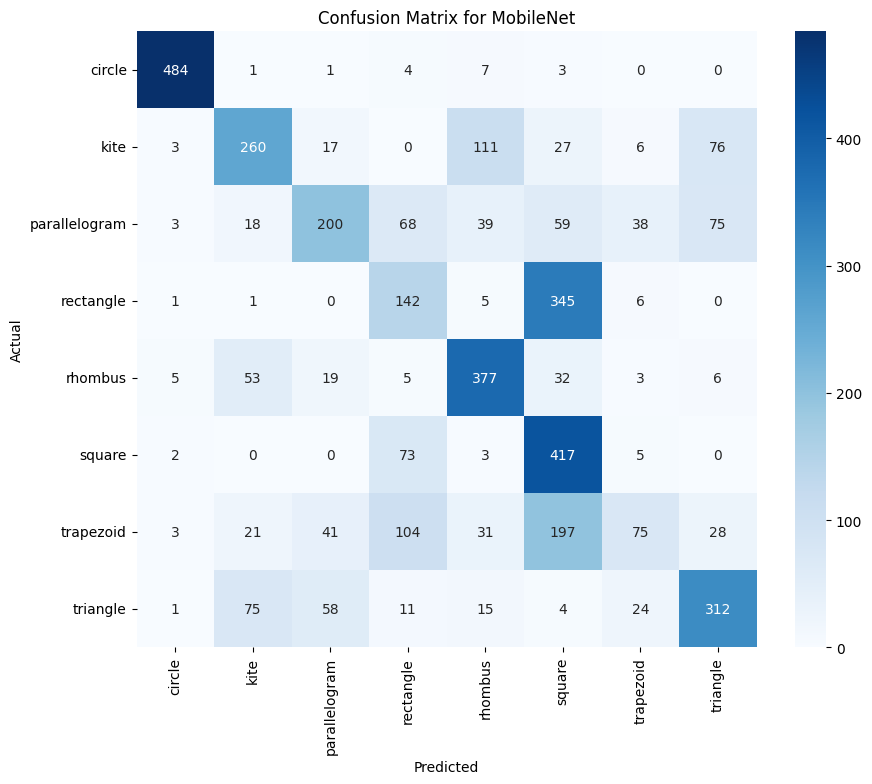

Classification Report for MobileNet:

               precision    recall  f1-score   support

       circle       0.96      0.97      0.97       500
         kite       0.61      0.52      0.56       500
parallelogram       0.60      0.40      0.48       500
    rectangle       0.35      0.28      0.31       500
      rhombus       0.64      0.75      0.69       500
       square       0.38      0.83      0.53       500
    trapezoid       0.48      0.15      0.23       500
     triangle       0.63      0.62      0.63       500

     accuracy                           0.57      4000
    macro avg       0.58      0.57      0.55      4000
 weighted avg       0.58      0.57      0.55      4000



In [13]:

# Confusion Matrix and Evaluation
def plot_confusion_matrix(model, test_data, model_name):
    y_pred = model.predict(test_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_data.classes

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred_classes, target_names=list(test_data.class_indices.keys())))

for model, name in zip(models, model_names):
    plot_confusion_matrix(model, test_data, name)


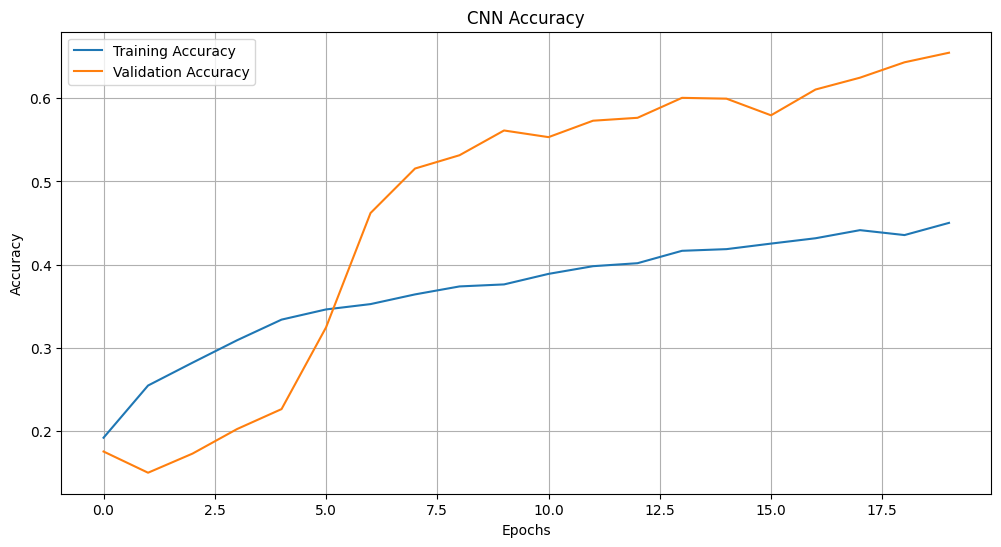

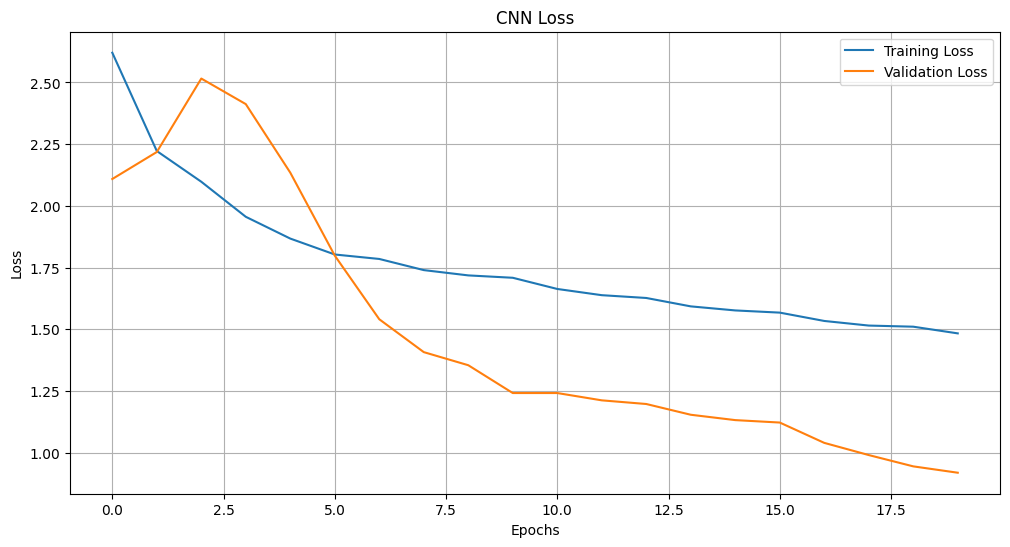

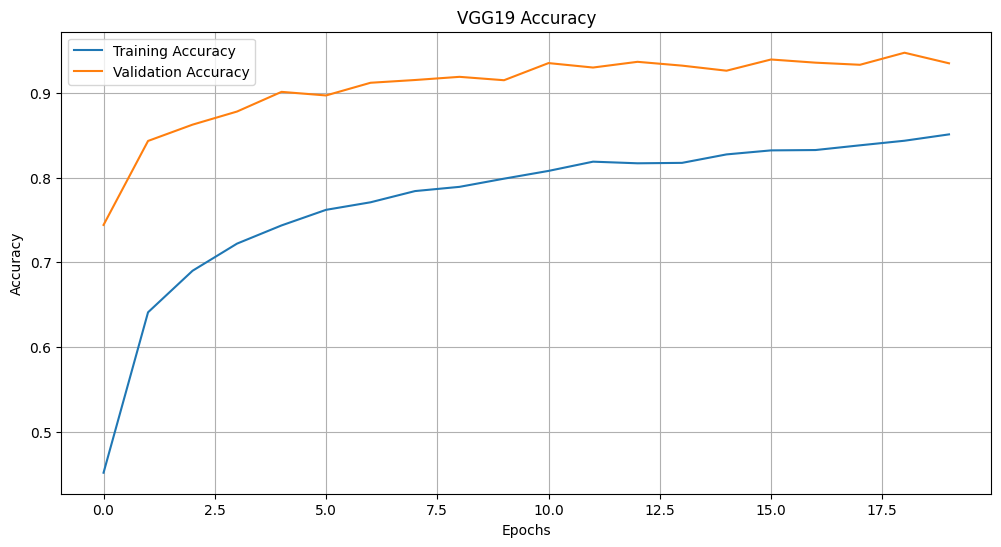

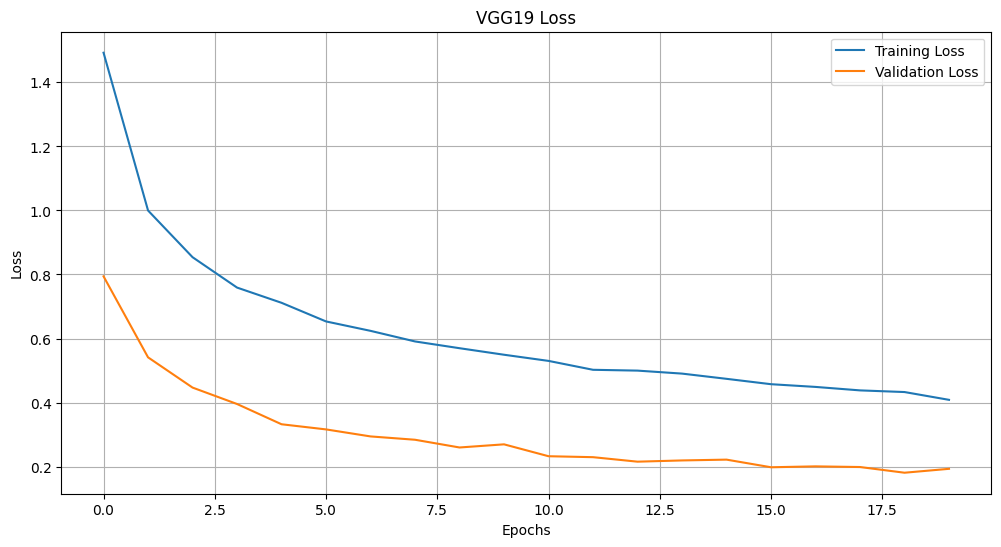

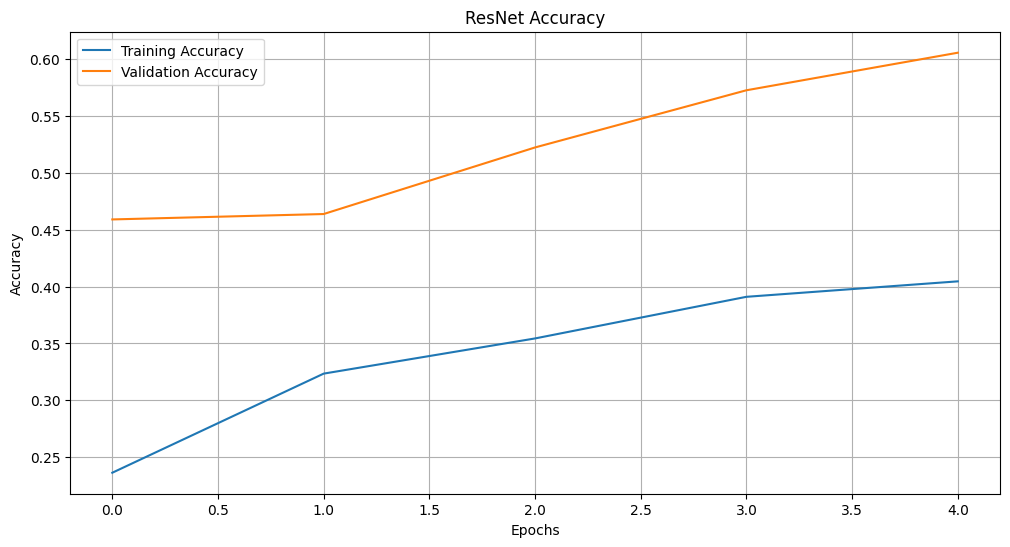

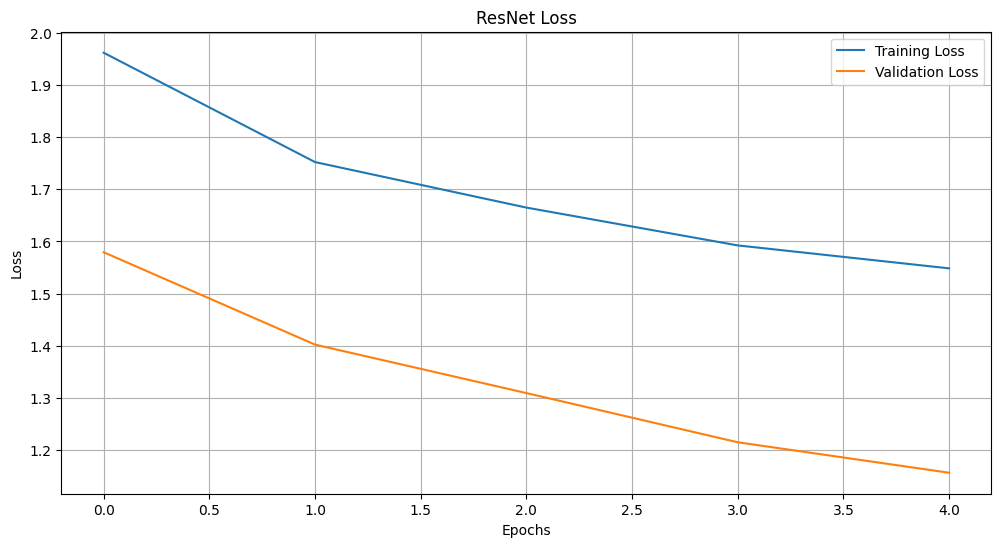

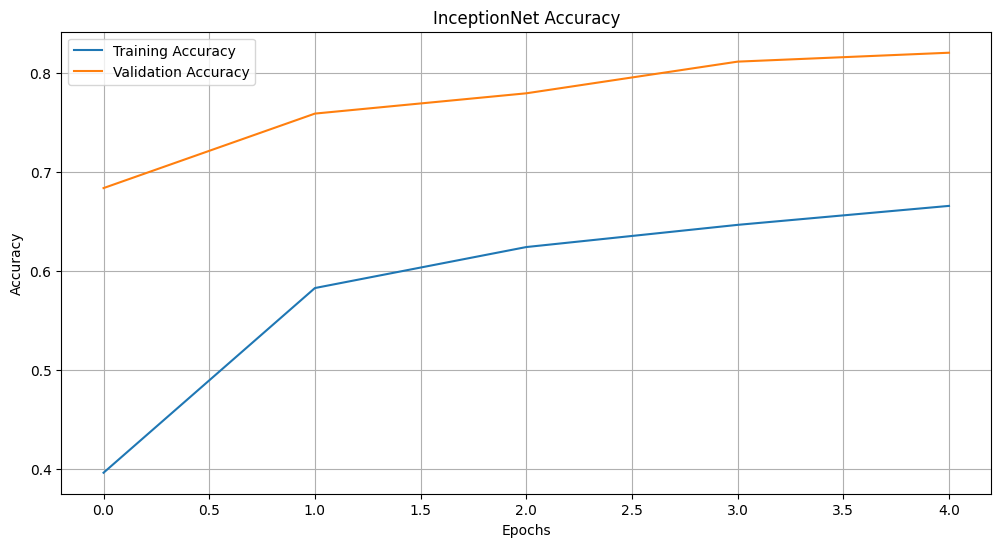

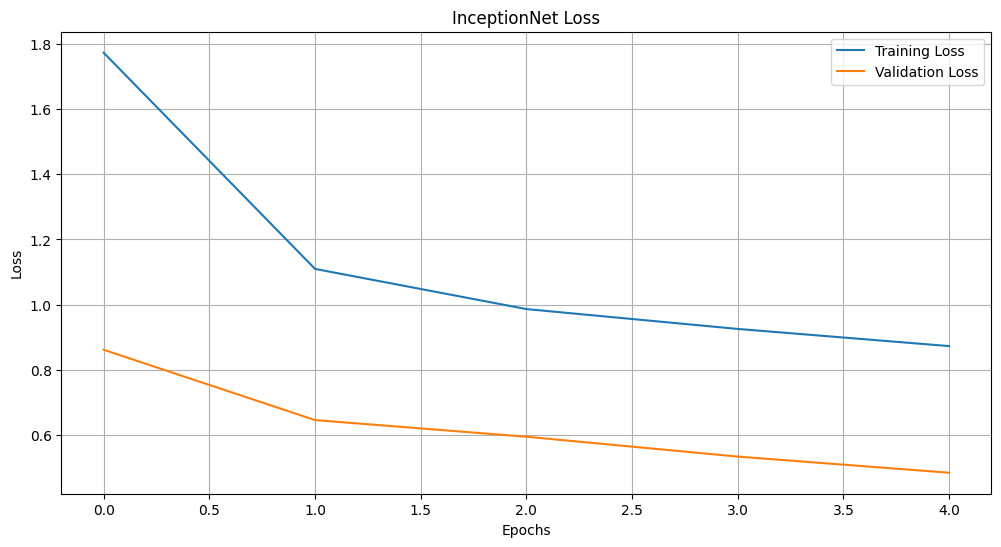

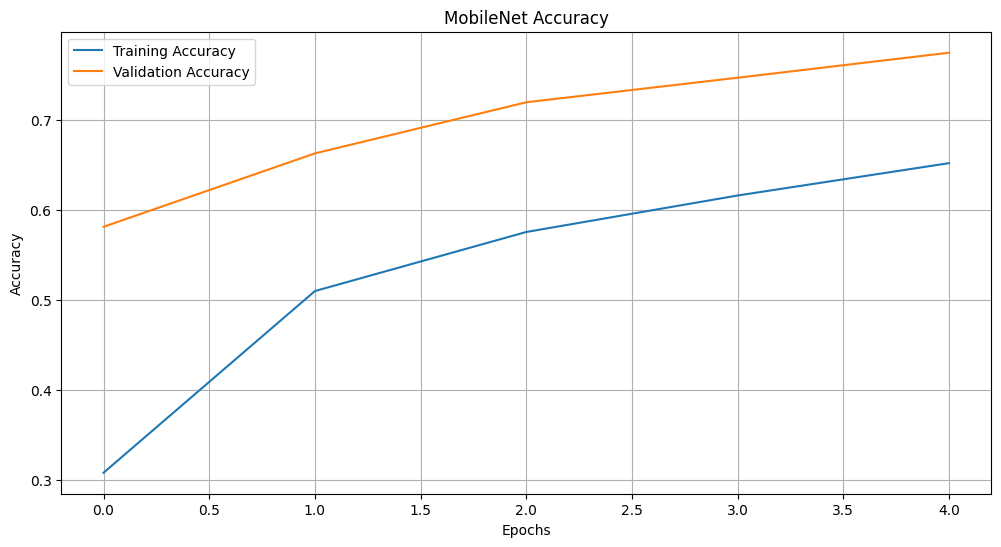

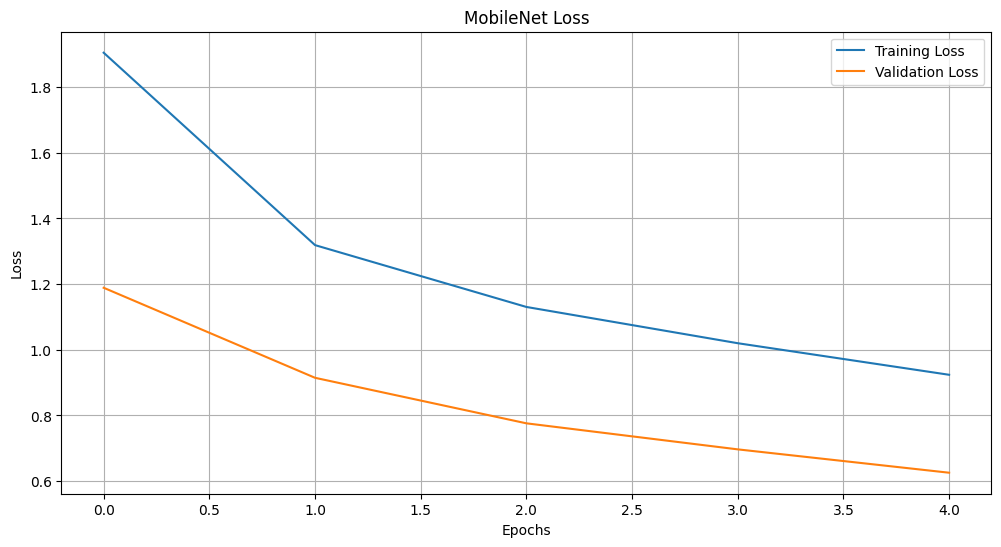

In [15]:
import matplotlib.pyplot as plt

def plot_training_curves(history, model_name):
    """
    Plots training and validation accuracy and loss.

    Parameters:
    - history: The history object returned from model.fit()
    - model_name: Name of the model (string).
    """
    # Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Store histories with corresponding model names
# Example usage for each model, accessing histories by index
plot_training_curves(histories[0], "CNN") # history_cnn is now histories[0]
plot_training_curves(histories[1], "VGG19") # history_vgg19 is now histories[1]
plot_training_curves(histories[2], "ResNet") # history_resnet is now histories[2]
plot_training_curves(histories[3], "InceptionNet") # history_inception is now histories[3]
plot_training_curves(histories[4], "MobileNet") # history_mobilenet is now histories[4]